In [1]:
from netgen.meshing import *
from netgen.csg import *
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\model')
#from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer
from BathPlateModel import BathPlateModel
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
from HtoOmega import HtoOmega
#model=Cylinder_Yaxis_1Layer(sigma=5e7)
model=BathPlateModel(holes=0, outerBox="box", boxx=0.2, boxy=0.2, boxz=0.2, msize=meshsize.coarse)
#model=BathPlateModel(holes=0,outerBox="sphere", boxx=0.2, div_thick=2)
DrawGeo(model.model)
mesh=model.mesh
Draw(mesh)

Bath Plate Model    holes: 0    Thickness: 0.00635
boxx=  0.2  boxy=  0.2  boxz=  0.2
div_thick=  1
name: conductor   mass: 4.191e-05   center: (-9.19197e-20, -2.9053e-19, 0)
name: air   mass: 0.00015824625000000016   center: (0, -3.55045e-19, 2.29027e-20)
name: reduced   mass: 0.06379984375000002   center: (0, -1.44176e-19, 9.03322e-20)
conductive_region: conductor
Conductor boundary: conductorBND
{'conductor': 32780000.0, 'to_side': 32780000.0, 'from_side': 32780000.0, 'air': 0, 'reduced': 0, 'hole1': 0, 'hole2': 0, 'default': 0}
{'conductor': 1.2566370614359173e-06, 'to_side': 1.2566370614359173e-06, 'from_side': 1.2566370614359173e-06, 'air': 1.2566370614359173e-06, 'reduced': 1.2566370614359173e-06, 'hole1': 1.2566370614359173e-06, 'hole2': 1.2566370614359173e-06, 'default': 1.2566370614359173e-06}
class HolePot: num= 0  holes
class MeasureFace: num= 0  faces


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [2]:
import math
jomega=True
f=50
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=False
feorder=2
mu=4e-7*math.pi
symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
air_region=model.air_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary
conductor_boundary=model.conductor_boundary

In [3]:
#field=UNIF(0,1,0,0)
field=model.coil.field
#coil=UNIF(0,0,0.01,0)
Bv=Bfield(field)
Hv=Bv/mu
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesOmega=H1(mesh, order=feorder, dirichlet=reduced_boundary, complex=jomega)
else:
    fesOmega=H1(mesh, order=feorder, complex=jomega)
fesT=HCurl(mesh, order=feorder, nograd=True, definedon=conductive_region, dirichlet=conductor_boundary, complex=jomega)     
fesTOmega=fesT*fesOmega
(T,omega),(W, psi) = fesTOmega.TnT() 
gfTOmega = GridFunction(fesTOmega)
gfT, gfOmega =gfTOmega.components
a= BilinearForm(fesTOmega)
a +=Mu*grad(omega)*grad(psi)*dx(air_region)
a +=Mu*(T+grad(omega))*(W+grad(psi))*dx(conductive_region)
a +=1/(s*Sigma)*curl(T)*curl(W)*dx(conductive_region)
with TaskManager():
    a.Assemble()
normal = specialcf.normal(mesh.dim)

In [4]:
surfaceOmega=HtoOmega(mesh, total_boundary, feorder, Hv)
# Calculate Dirichlet condition terms
#gfOmega.Set(Ov, BND, mesh.Boundaries(total_boundary))
gfOmega.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))

enter iccg_solve
Dof= 858    matrix size= 3609.0
shift parameter= 1.0
minimum residual= 7.192513563708408e-17  at iteraions:  38
結果のノルム: 2.1559112776003444e-15
power=  350080.4925418871


In [5]:
f = LinearForm(fesTOmega)
f +=Mu*grad(gfOmega)*grad(psi)*dx(reduced_region)
with TaskManager():
    f.Assemble() 
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesTOmega.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesTOmega.FreeDofs()] = fcut

# Add Neumann condition terms
f += (normal*Bv)*psi*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfTOmega = GridFunction(fesTOmega)   #Clear gfA
gfTOmega=solver.iccg_solve(fesTOmega, gfTOmega, a, f.vec.FV(), tol=1.e-10, max_iter=200, accel_factor=0, complex=jomega) 
gfT, gfOmega=gfTOmega.components

fesOt=H1(mesh, order=feorder, definedon=total_region, complex=jomega)
fesOr=H1(mesh, order=feorder, definedon=reduced_region, complex=jomega)
Ot=GridFunction(fesOt)
Orr=GridFunction(fesOr)
Oxr=GridFunction(fesOr)

Ot.Set(gfOmega,VOL, definedon=total_region)
Orr.Set(gfOmega,VOL, definedon=reduced_region)
Oxr.Set(surfaceOmega, BND, mesh.Boundaries(total_boundary))
#Oxr.Set(Ov, BND, mesh.Boundaries(total_boundary))

Bt=(gfT+grad(Ot))*Mu
Or=Orr-Oxr
Br=(grad(Orr)-grad(Oxr))*mu
Bfield=Bt+Br+Bs
Jfield=curl(gfT)

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))


enter iccg_solve
Dof= 12886    matrix size= 273516.0
shift parameter= 1.01
minimum residual= 5.689242067539249e-07  at iteraions:  28
結果のノルム: 0.005334960115681009
power=  (0.026888417142086056+0.0022206004632089526j)
center magnetic field =  ((0.004603205752154496-0.0002860447043290564j), (-1.7938015670873053e-05+1.2480739337527634e-05j), (0.005713515253043031-0.00358302633872844j))


In [6]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region), mesh)
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  0.349095359071325


In [7]:
if jomega==True:
    print("****** Bfield.real ******")
    Draw (Bfield.real, mesh, order=3, deformation=False) 
    print("****** Bfield.imag ******")
    Draw (Bfield.imag, mesh, order=3, deformation=False) 
    print("****** Jfield.real ******")
    Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("****** Jfield.imag ******")
    Draw (Jfield.imag, mesh, order=3, deformation=False) 
else:
    print("****** Bfield ******")
    Draw (Bfield, mesh, order=3, deformation=False) 
    print("****** Jfield ******")
    Draw (Jfield, mesh, order=3, deformation=False) 

****** Bfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Bfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.real ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

****** Jfield.imag ******


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Apply Coil field, 　Dirichlet=False, feOrder=3

B field real [0, 0.00354]
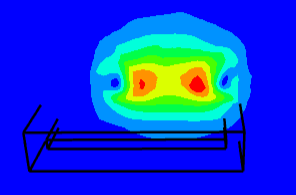

B field img [0, 0.00475]
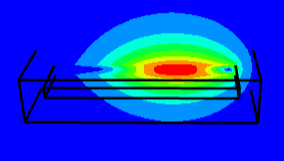

center magnetic field =  ((0.0046114017915582835-0.0002700835030015863j), (-2.871086876578396e-08+6.144269445770649e-08j), (0.005696655611467302-0.0035804087837488048j))

Apply Coil field, 　Dirichlet=False, feOrder=3

J field real [0, 5.97e5]
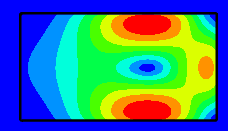

J field imag [0, 1.76e6]
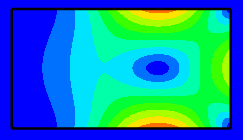

Average Joule loss=  0.34934970207307614  <-->0.3486242392846813 (A-Phi, feOrder=3)

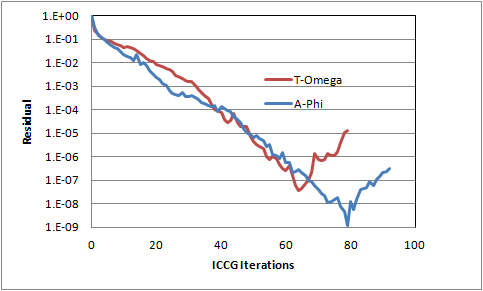